# Import Libraries

In [1]:
import pandas as pd
import joblib
import time

import numpy as np
from numpy import nan
import geopandas as gpd
from shapely.geometry import Point, box

from collections import defaultdict
from itertools import cycle

# Sklearn imports
from sklearn.metrics import accuracy_score, roc_curve, auc, roc_auc_score, classification_report
from sklearn.preprocessing import label_binarize, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance

# PyTorch imports
import torch
import torch.nn as nn
from captum.attr import IntegratedGradients

import matplotlib.pyplot as plt


import os
os.chdir(r"E:\Data challenge")

In [2]:
from classes.my_classes import Prepare_Data

In [3]:
data_preparer = Prepare_Data(
    data_flood_path=r"data/Flood/flood_risk_results.csv",
    data_drias_path=r"data/Drias_data/RCP_4.5_with_distance.csv",
    data_clay_path=r"data/Flood/clay_risk_results.csv"
    )

In [4]:
data_merged = data_preparer.prepare_all()

Chargement des données...
Données chargées avec succès!

Préparation des données clay...
Données clay préparées!

Préparation des données Flood...
Données Flood préparées pour les 3 scénarios!

Fusion des datasets...
Datasets fusionnés!

Nettoyage des données fusionnées...
Données nettoyées!

Préparation des données terminée!
Shape du dataset final: (242487, 19)


# Modelization of Flood Risk Class

### Preparing Data for Training

In [5]:
df = data_merged.copy()

y = df["scenario"]
X = df.drop(columns=["scenario", "ht_min", "ht_max"])

#X = X.select_dtypes(include=["int32", "int64", "float64"])

print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")
print(f"\nDistribution des classes:")
print(y.value_counts())

Shape de X: (242487, 16)
Shape de y: (242487,)

Distribution des classes:
scenario
0.0    220725
3.0      7731
2.0      7326
1.0      6705
Name: count, dtype: int64


**Classes** are **unequally distributed**, so we'll **add weights** to the training.

In [6]:
# Matching risk level to value for training
risk_levels = {
    'low': 3.0,
    'mid': 2.0,
    'high': 1.0
}

# Create dictionnaries for our Models and Results
models = {}
results = {}

In [7]:
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Define risk levels (assuming 1.0=low, 2.0=mid, 3.0=high based on your data)
risk_levels = {
    'low': 3.0,
    'mid': 2.0,
    'high': 1.0
}

models = {}
results = {}

# Train separate binary classifier for each risk level
for risk_name, risk_value in risk_levels.items():
    print(f"\n{'='*50}")
    print(f"Training model for {risk_name.upper()} risk (class {risk_value})")
    print(f"{'='*50}")
    
    # Clean dataset
    data_df = X.copy()
    data_df['scenario'] = y
    
    print(f"Before deduplication: {len(data_df)} samples")
    print(f"Scenario distribution: {data_df['scenario'].value_counts().to_dict()}")
    
    # Create priority: 1 for current risk, 2 for no risk (0.0), 3 for other risks
    data_df['priority'] = data_df['scenario'].apply(lambda x: 1 if x == risk_value else (2 if x == 0.0 else 3))
    
    # Sort by priority and drop duplicates on features (keep first = highest priority)
    data_df_sorted = data_df.sort_values('priority')
    data_df_dedup = data_df_sorted.drop_duplicates(subset=X.columns.tolist(), keep='first')
    
    # Remove rows with priority=3 (other risk levels)
    data_df_clean = data_df_dedup[data_df_dedup['priority'] != 3].copy()
    
    print(f"After deduplication: {len(data_df_clean)} samples")
    print(f"Scenario distribution: {data_df_clean['scenario'].value_counts().to_dict()}")
    
    # Create binary target
    X_clean = data_df_clean[X.columns]
    y_clean = (data_df_clean['scenario'] == risk_value).astype(int)
    
    print(f"Binary target distribution: {y_clean.value_counts().to_dict()}")
    
    # NOW split into train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_clean, 
        test_size=0.2, 
        random_state=42,
        stratify=y_clean  # maintain class balance
    )
    
    print(y_train.value_counts())
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    
    from sklearn.ensemble import RandomForestClassifier

    rf = RandomForestClassifier(
        n_estimators=500,          # more trees = more stable AUC
        max_depth=None,            # let trees grow fully first
        min_samples_split=5,
        min_samples_leaf=2,
        max_features="sqrt",       # important for generalization
        class_weight="balanced",   # handles imbalance directly
        n_jobs=-1,
        random_state=42
    )

    rf.fit(X_train, y_train)

    model = rf

    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f"\nAccuracy: {accuracy:.4f}")
    print(f"ROC AUC: {auc:.4f}")
    
    # Store model and results
    models[risk_name] = model
    results[risk_name] = {
        'accuracy': accuracy,
        'auc': auc,
        'y_test': y_test,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }



Training model for LOW risk (class 3.0)
Before deduplication: 242487 samples
Scenario distribution: {0.0: 220725, 3.0: 7731, 2.0: 7326, 1.0: 6705}
After deduplication: 8981 samples
Scenario distribution: {0.0: 8122, 3.0: 859}
Binary target distribution: {0: 8122, 1: 859}
scenario
0    6497
1     687
Name: count, dtype: int64
Train size: 7184, Test size: 1797

Accuracy: 0.9343
ROC AUC: 0.9291

Training model for MID risk (class 2.0)
Before deduplication: 242487 samples
Scenario distribution: {0.0: 220725, 3.0: 7731, 2.0: 7326, 1.0: 6705}
After deduplication: 8981 samples
Scenario distribution: {0.0: 8167, 2.0: 814}
Binary target distribution: {0: 8167, 1: 814}
scenario
0    6533
1     651
Name: count, dtype: int64
Train size: 7184, Test size: 1797

Accuracy: 0.9366
ROC AUC: 0.9079

Training model for HIGH risk (class 1.0)
Before deduplication: 242487 samples
Scenario distribution: {0.0: 220725, 3.0: 7731, 2.0: 7326, 1.0: 6705}
After deduplication: 8981 samples
Scenario distribution: {0

### Vizualize Results

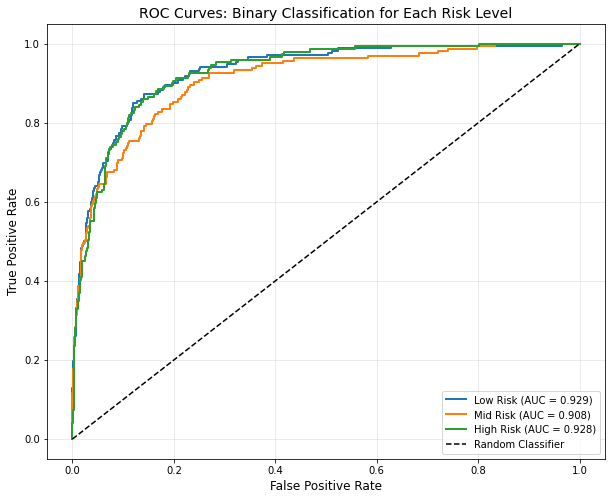

In [8]:
# Tracer les courbes ROC pour tous les modèles
plt.figure(figsize=(10, 8))

for risk_name in risk_levels.keys():
    fpr, tpr, _ = roc_curve(results[risk_name]['y_test'], 
                             results[risk_name]['y_pred_proba'])
    auc_val = results[risk_name]['auc']
    plt.plot(fpr, tpr, label=f'{risk_name.capitalize()} Risk (AUC = {auc_val:.3f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves: Binary Classification for Each Risk Level', fontsize=14)
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

### Extract Importance of variables

##### Model for High Risk Class Prediction

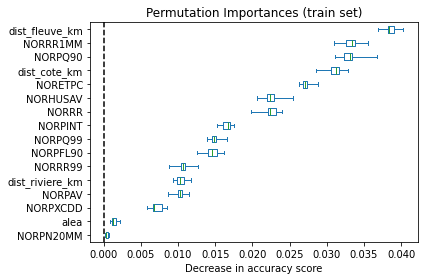

In [9]:
result = permutation_importance(models['high'], X_train, y_train, n_repeats=10, random_state=42, n_jobs=2)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

##### Model for Mid Risk Class Prediction

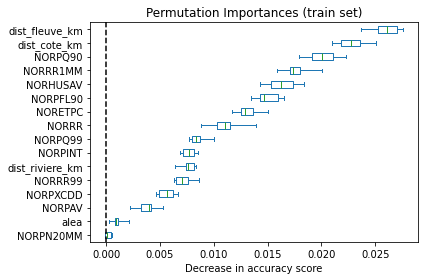

In [10]:
result = permutation_importance(models['mid'], X_train, y_train, n_repeats=10, random_state=42, n_jobs=2)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

##### Model for Low Risk Class Prediction

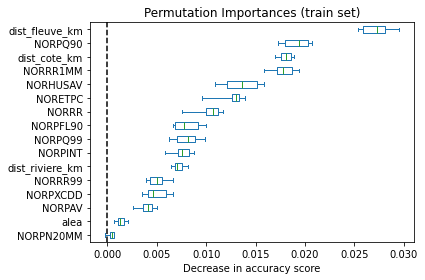

In [11]:
result = permutation_importance(models['low'], X_train, y_train, n_repeats=10, random_state=42, n_jobs=2)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)

ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances (train set)")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

# Modelisation of our Heights

### Preparing Datas for Training

In [12]:
# Fixe our seeds
torch.manual_seed(123)
np.random.seed(123)

In [13]:
df_height = data_merged.copy()

# Replace sentinel missing-value codes with NaN
df_height['ht_max'] = df_height['ht_max'].apply(lambda x: x if x <= 6 else np.nan)
df_height['ht_min'] = df_height['ht_min'].apply(lambda x: x if x <= 4 else np.nan)

# Drop rows where either target is missing
df_height.dropna(subset=['ht_min', 'ht_max'], inplace=True)

# Each unique value in ht_min / ht_max becomes its own class.
# We just need sorted unique values → will be mapped to 0, 1, 2, … later.
unique_min = sorted(df_height['ht_min'].unique())
unique_max = sorted(df_height['ht_max'].unique())

print(f"Valeurs uniques ht_min ({len(unique_min)}) : {unique_min}")
print(f"Valeurs uniques ht_max ({len(unique_max)}) : {unique_max}")

# --- Split features / targets ---
y_height = df_height[["ht_min", "ht_max"]]
X_height = df_height.drop(columns=["ht_min", "ht_max"])

print(f"Shape de X_height: {X_height.shape}")
print(f"Shape de y_height: {y_height.shape}")


Valeurs uniques ht_min (4) : [0.0, 0.5, 1.0, 2.0]
Valeurs uniques ht_max (7) : [0.0, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0]
Shape de X_height: (235638, 17)
Shape de y_height: (235638, 2)


In [14]:
X_train_h, X_test_h, y_train_h, y_test_h = train_test_split(
    X_height, y_height, test_size=0.3, random_state=42
)

scaler = StandardScaler()

features_to_scale = [
    'NORPAV', 'NORRR', 'NORRR1MM', 'NORPN20MM', 'NORPFL90',
    'NORPXCDD', 'NORPINT', 'NORPQ90', 'NORPQ99', 'NORRR99',
    'NORHUSAV', 'NORETPC',
    'dist_fleuve_km', 'dist_riviere_km', 'dist_cote_km'
]

X_train_h = X_train_h.copy()
X_test_h  = X_test_h.copy()

X_train_h[features_to_scale] = scaler.fit_transform(X_train_h[features_to_scale])
X_test_h[features_to_scale]  = scaler.transform(X_test_h[features_to_scale])
print("Données standardisées!")


Données standardisées!


In [15]:
X_train_tensor = torch.tensor(X_train_h.to_numpy(), dtype=torch.float32)
X_test_tensor  = torch.tensor(X_test_h.to_numpy(),  dtype=torch.float32)

# y must be long (int64) for CrossEntropyLoss
y_train_tensor = torch.tensor(y_train_h.values, dtype=torch.long)
y_test_tensor  = torch.tensor(y_test_h.values,  dtype=torch.long)

In [16]:
def encode_labels(y_tensor, unique_values_per_col):
    """
    Map each column's values to 0, 1, 2, … using a fixed vocabulary.
    Args:
        y_tensor              – LongTensor (N, num_targets)
        unique_values_per_col – list of sorted unique values, one per column
                                (built from the full dataset BEFORE the split)
    Returns:
        y_encoded  – LongTensor with contiguous indices
        label_maps – list of dicts  {original_value: new_index}  per column
    """
    label_maps = []
    y_encoded  = torch.zeros_like(y_tensor)

    for col in range(y_tensor.shape[1]):
        mapping = {v: i for i, v in enumerate(unique_values_per_col[col])}
        label_maps.append(mapping)

        for orig, new in mapping.items():
            y_encoded[:, col][y_tensor[:, col] == orig] = new

    return y_encoded, label_maps


In [17]:
unique_values_per_col = [unique_min, unique_max]

y_train_tensor, label_maps = encode_labels(y_train_tensor, unique_values_per_col)
y_test_tensor,  _ = encode_labels(y_test_tensor,  unique_values_per_col)

num_classes_min = len(label_maps[0])
num_classes_max = len(label_maps[1])

print(f"Nombre de classes pour ht_min: {num_classes_min}")
print(f"Nombre de classes pour ht_max: {num_classes_max}")


Nombre de classes pour ht_min: 4
Nombre de classes pour ht_max: 7


### Rebalance our Classes

In [18]:
def get_class_weights(y_col, num_classes, eps=1e-6):
    counts  = torch.bincount(y_col, minlength=num_classes).float()
    counts  = torch.clamp(counts, min=eps)
    weights = counts.sum() / (num_classes * counts)
    return weights

weight_min = get_class_weights(y_train_tensor[:, 0], num_classes_min)
weight_max = get_class_weights(y_train_tensor[:, 1], num_classes_max)

print(f"Poids pour ht_min: {weight_min}")
print(f"Poids pour ht_max: {weight_max}")


Poids pour ht_min: tensor([2.5352e-01, 4.1237e+10, 3.7183e+01, 3.4887e+01])
Poids pour ht_max: tensor([1.5157e-01, 2.3564e+10, 3.1968e+00, 2.3564e+10, 2.3898e+01, 2.2855e+01,
        2.6182e+02])


### Creating our architecture

In [19]:
# Définition du modèle Dense Neural Network
class DenseNetClassifier(nn.Module):
    def __init__(self, input_dim, num_classes_min, num_classes_max):
        super().__init__()
        
        # Branche pour ht_min
        self.ht_min = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes_min)
        )
        
        # Branche pour ht_max
        self.ht_max = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, num_classes_max)
        )

    def forward(self, x):
        return self.ht_min(x), self.ht_max(x)

# Initialiser le modèle
model_height = DenseNetClassifier(X_train_tensor.shape[1], num_classes_min, num_classes_max)

#print("Model for heights prediction")
#print(model_height)

### Training our Model

In [20]:

# -------------------------------
# Loss and optimizer
# -------------------------------
criterion_min = nn.CrossEntropyLoss(weight=weight_min)
criterion_max = nn.CrossEntropyLoss(weight=weight_max)
optimizer = torch.optim.Adam(model_height.parameters(), lr=1e-2)

# -------------------------------
# Training loop
# -------------------------------
epochs = 1000
for epoch in range(epochs):
    model_height.train()
    optimizer.zero_grad()

    ht_min_logits, ht_max_logits = model_height(X_train_tensor)
    loss_min = criterion_min(ht_min_logits, y_train_tensor[:,0])
    loss_max = criterion_max(ht_max_logits, y_train_tensor[:,1])
    train_loss = loss_min + loss_max

    train_loss.backward()
    optimizer.step()

    # Validation
    model_height.eval()
    with torch.no_grad():
        val_min_logits, val_max_logits = model_height(X_test_tensor)
        val_loss = criterion_min(val_min_logits, y_test_tensor[:,0]) + \
                   criterion_max(val_max_logits, y_test_tensor[:,1])

        # Accuracy and macro-F1
        val_min_pred = torch.argmax(val_min_logits, dim=1)
        val_max_pred = torch.argmax(val_max_logits, dim=1)
        acc_min = accuracy_score(y_test_tensor[:,0].numpy(), val_min_pred.numpy())
        acc_max = accuracy_score(y_test_tensor[:,1].numpy(), val_max_pred.numpy())

    if epoch % 20 == 0:
        print(f"Epoch {epoch+1:04d} | "
              f"Train Loss: {train_loss.item():.4f} | "
              f"Val Loss: {val_loss.item():.4f} | ")

Epoch 0001 | Train Loss: 3.4226 | Val Loss: 3.2781 | 
Epoch 0021 | Train Loss: 1.5109 | Val Loss: 1.4833 | 
Epoch 0041 | Train Loss: 0.8860 | Val Loss: 0.8916 | 
Epoch 0061 | Train Loss: 0.6067 | Val Loss: 0.6256 | 
Epoch 0081 | Train Loss: 0.4875 | Val Loss: 0.5050 | 
Epoch 0101 | Train Loss: 0.4214 | Val Loss: 0.4388 | 
Epoch 0121 | Train Loss: 0.3761 | Val Loss: 0.3945 | 
Epoch 0141 | Train Loss: 0.3424 | Val Loss: 0.3609 | 
Epoch 0161 | Train Loss: 0.3169 | Val Loss: 0.3313 | 
Epoch 0181 | Train Loss: 0.2936 | Val Loss: 0.3112 | 
Epoch 0201 | Train Loss: 0.2751 | Val Loss: 0.2914 | 
Epoch 0221 | Train Loss: 0.2613 | Val Loss: 0.2810 | 
Epoch 0241 | Train Loss: 0.2469 | Val Loss: 0.2591 | 
Epoch 0261 | Train Loss: 0.2322 | Val Loss: 0.2444 | 
Epoch 0281 | Train Loss: 0.2215 | Val Loss: 0.2358 | 
Epoch 0301 | Train Loss: 0.2134 | Val Loss: 0.2221 | 
Epoch 0321 | Train Loss: 0.2022 | Val Loss: 0.2142 | 
Epoch 0341 | Train Loss: 0.1953 | Val Loss: 0.2068 | 
Epoch 0361 | Train Loss: 0.1

### Evaluate our Model

In [21]:
def decode_predictions(pred_tensor, mapping):
    inv_map = {v: k for k, v in mapping.items()}
    decoded = pred_tensor.clone().float()
    for k, v in inv_map.items():
        decoded[pred_tensor == k] = v
    return decoded


In [22]:
# Inférence
model_height.eval()
with torch.no_grad():
    ht_min_logits, ht_max_logits = model_height(X_test_tensor)
    ht_min_pred = torch.argmax(ht_min_logits, dim=1)
    ht_max_pred = torch.argmax(ht_max_logits, dim=1)

ht_min_pred_dec = decode_predictions(ht_min_pred, label_maps[0])
ht_max_pred_dec = decode_predictions(ht_max_pred, label_maps[1])

y_pred_df = pd.DataFrame({
    'ht_min': ht_min_pred_dec.numpy(),
    'ht_max': ht_max_pred_dec.numpy()
})

y_test_df = pd.DataFrame({
    'ht_min': decode_predictions(y_test_tensor[:,0], label_maps[0]).numpy(),
    'ht_max': decode_predictions(y_test_tensor[:,1], label_maps[1]).numpy()
})


In [23]:
# Métriques
print("Accuracy ht_min:", accuracy_score(y_test_df['ht_min'], y_pred_df['ht_min']))
print("Accuracy ht_max:", accuracy_score(y_test_df['ht_max'], y_pred_df['ht_max']))

print("\nClassification report ht_min:\n", 
      classification_report(y_test_df['ht_min'], y_pred_df['ht_min']))
print("\nClassification report ht_max:\n", 
      classification_report(y_test_df['ht_max'], y_pred_df['ht_max']))

Accuracy ht_min: 0.9852741470039043
Accuracy ht_max: 0.9913568720647316

Classification report ht_min:
               precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     69707
         1.0       0.45      1.00      0.62       493
         2.0       0.53      1.00      0.70       492

    accuracy                           0.99     70692
   macro avg       0.66      1.00      0.77     70692
weighted avg       0.99      0.99      0.99     70692


Classification report ht_max:
               precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     66643
         1.0       0.90      0.94      0.92      3141
         2.0       0.73      0.99      0.84       454
         3.0       0.79      1.00      0.88       418
         4.0       0.86      1.00      0.92        36

    accuracy                           0.99     70692
   macro avg       0.86      0.99      0.91     70692
weighted avg       0.99      0.99      0.99     7

### Extract Importance Feature (with Integrated Gradients)

In [24]:
# Définir les fonctions forward pour chaque output
def forward_min(x):
    return model_height.ht_min(x)

def forward_max(x):
    return model_height.ht_max(x)

# Integrated Gradients
ig_min = IntegratedGradients(forward_min)
ig_max = IntegratedGradients(forward_max)

# Calculer les attributions sur un échantillon du test set
sample_size = 100
sample_indices = np.random.choice(len(X_test_tensor), sample_size, replace=False)
X_sample = X_test_tensor[sample_indices]
baseline = torch.zeros_like(X_sample)

with torch.no_grad():
    target_min = torch.argmax(model_height.ht_min(X_sample), dim=1)
    target_max = torch.argmax(model_height.ht_max(X_sample), dim=1)

# Calculer les attributions
attributions_min = ig_min.attribute(X_sample, baseline, target=target_min)
attributions_max = ig_max.attribute(X_sample, baseline, target=target_max)

# Moyenner sur les échantillons
attr_min = attributions_min.mean(dim=0).numpy()
attr_max = attributions_max.mean(dim=0).numpy()

print("Features Importance Extracted")

Features Importance Extracted


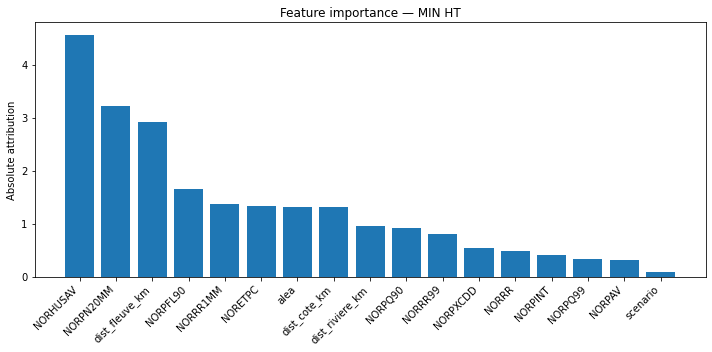

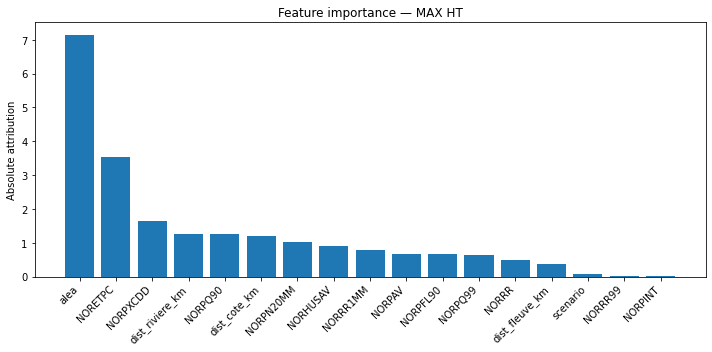

In [25]:
# Visualiser l'importance des features
feature_names = X_height.columns.tolist()

# Trier par importance
idx_min = np.argsort(np.abs(attr_min))[::-1]
idx_max = np.argsort(np.abs(attr_max))[::-1]

plt.figure(figsize=(10, 5))
plt.bar(np.array(feature_names)[idx_min], np.abs(attr_min)[idx_min])
plt.xticks(rotation=45, ha="right")
plt.title("Feature importance — MIN HT")
plt.ylabel("Absolute attribution")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(np.array(feature_names)[idx_max], np.abs(attr_max)[idx_max])
plt.xticks(rotation=45, ha="right")
plt.title("Feature importance — MAX HT")
plt.ylabel("Absolute attribution")
plt.tight_layout()
plt.show()

# Export our Models

In [26]:
# Export our randomforest models
for risk, model in models.items():
    joblib.dump(model, f"model/RandForestClassifier_{risk}.pkl")

In [27]:
# Export our model_height
torch.save(model_height, r'model/model_ht.pth')
joblib.dump(scaler, r"model/ht_scaler.pkl")
torch.save(model_height.state_dict(), r'model/model_ht_state.pth')